In [6]:
import numpy as np 
import pandas as pd
#import plotly.plotly as py
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
#%matplotlib inline
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,make_scorer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import os
import scikitplot as skplt
import seaborn as sns
import time
from catboost import CatBoostClassifier, Pool, MetricVisualizer

In [7]:
data=pd.read_csv('df_train.csv')
data = data.dropna()

In [8]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from collections import defaultdict

In [9]:
def plot_top_ngrams(text,ngrams=(1,1),top=10,max_features=100,color='rgba(0,255,255,0.5)'):
    cv=CountVectorizer(ngram_range=ngrams,max_features=max_features)
    trans_text=cv.fit_transform(text)
    col_sum=trans_text.sum(axis=0)
    word_index=[(word,col_sum[0,idx]) for word,idx in cv.vocabulary_.items()]
    sorted_word_index=sorted(word_index,key=lambda x:x[1],reverse=True)
    top_words_index=sorted_word_index[:top]
    top_words=[element[0] for element in top_words_index]
    counts=[element[1] for element in top_words_index]
    df = pd.DataFrame(zip(top_words,counts))
    df.columns = ['top_words', 'counts']
    df.set_index('top_words', inplace=True)
    df.sort_values('counts', ascending=False)
    df.plot(y='counts', kind='bar', legend=False)

In [10]:
data.target.value_counts()

4    3202
0    1040
5    1032
3     265
1     231
2     227
Name: target, dtype: int64

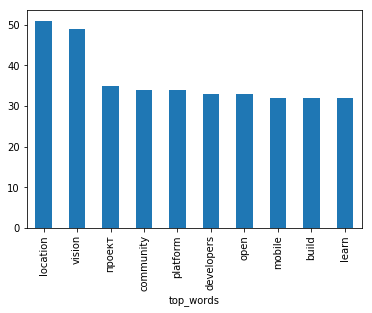

In [21]:
plot_top_ngrams(data[data.target==3].text,ngrams=(1,1),top=10,color='rgba(128,0,0,0.5)')

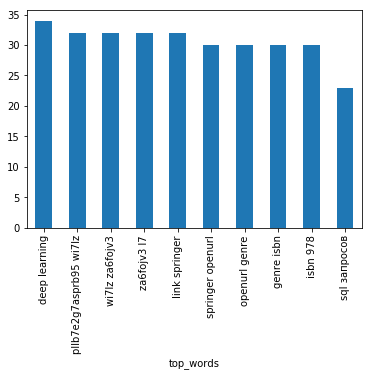

In [19]:
plot_top_ngrams(data[data.target==5].text,ngrams=(2,2),top=10,color='rgba(128,0,0,0.5)')

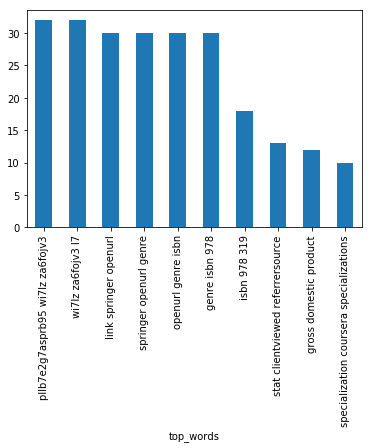

In [20]:
plot_top_ngrams(data[data.target==5].text,ngrams=(3,3),top=10,color='rgba(128,0,0,0.5)')

In [8]:
X = data['text']
Y = data['target']

train_X , val_X, train_y, val_y = train_test_split(X, Y, test_size=0.1, random_state=42)

In [9]:
print(train_X.shape)
print(val_X.shape)
print(train_y.shape)
print(val_y.shape)

(7210,)
(802,)
(7210,)
(802,)


In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [11]:
cv=CountVectorizer(ngram_range=(1,3), analyzer='word')
train_X_cv=cv.fit_transform(train_X.values)
val_X_cv=cv.transform(val_X.values)

In [12]:
tsvd = TruncatedSVD(n_components=25, random_state=42)
train_X_svd = tsvd.fit_transform(train_X_cv)
val_X_svd = tsvd.transform(val_X_cv)
tsne = TSNE(n_components=2, random_state=42)
train_X_tsne = tsne.fit_transform(train_X_svd)

In [13]:
data.target.value_counts()

0    4839
1    2087
2    1086
Name: target, dtype: int64

In [14]:
label = np.sort(train_y.unique()).tolist()

In [15]:
label

[0, 1, 2]

In [16]:
def get_model(model, train_X, train_y, val_X):
    model.fit(train_X, train_y)
    pred_probs = model.predict_proba(val_X)
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)
    score_train = f1_score(train_y, pred_train, average=None)
    score_val = f1_score(val_y, pred_val, average=None)
    return (
        pred_probs,
        pred_train,
        pred_val,
        score_train,
        score_val,
    )

In [17]:
def get_confusion_matrix(val_y, pred, title):
    cm = confusion_matrix(val_y, pred, labels=label)
    #plt.figure(figsize=(15, 15))
    #sns.heatmap(cm, annot=True)
    #plt.title(title)
    #plt.ylabel("True labels")
    #plt.xlabel("Predicted labels")
    #plt.show()
    fig = plt.figure(figsize=(15, 15))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cbar=False, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix' + title); 
    ax.xaxis.set_ticklabels(label);
    ax.yaxis.set_ticklabels(label);


def get_roc_curve(val_y, pred_probs, title):
    #plt.figure(figsize=(15, 15))
    plt.title(title)
    skplt.metrics.plot_roc(val_y, pred_probs, figsize=(15, 15))

In [18]:
def get_confusion_proba_matrix(val_y, pred, title):
    cm = confusion_matrix(val_y, pred, labels=label)
    #plt.figure(figsize=(15, 15))
    #sns.heatmap(cm, annot=True)
    #plt.title(title)
    #plt.ylabel("True labels")
    #plt.xlabel("Predicted labels")
    #plt.show()
    fig = plt.figure(figsize=(15, 15))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cbar=False, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix' + title); 
    ax.xaxis.set_ticklabels(label);
    ax.yaxis.set_ticklabels(label);


In [33]:
model = LogisticRegression(random_state=42, class_weight='balanced')

In [34]:
pred_probs, pred_train, pred_val, score_train, score_val = get_model(model, train_X_cv, train_y, val_X_cv)

In [35]:
score_train

array([1., 1., 1.])

In [36]:
score_val

array([0.84990619, 0.64361702, 0.65432099])

In [37]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

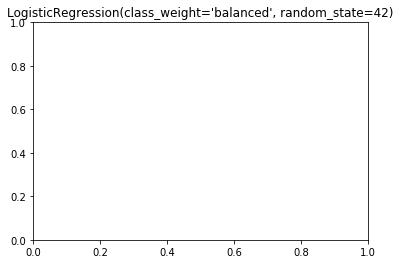

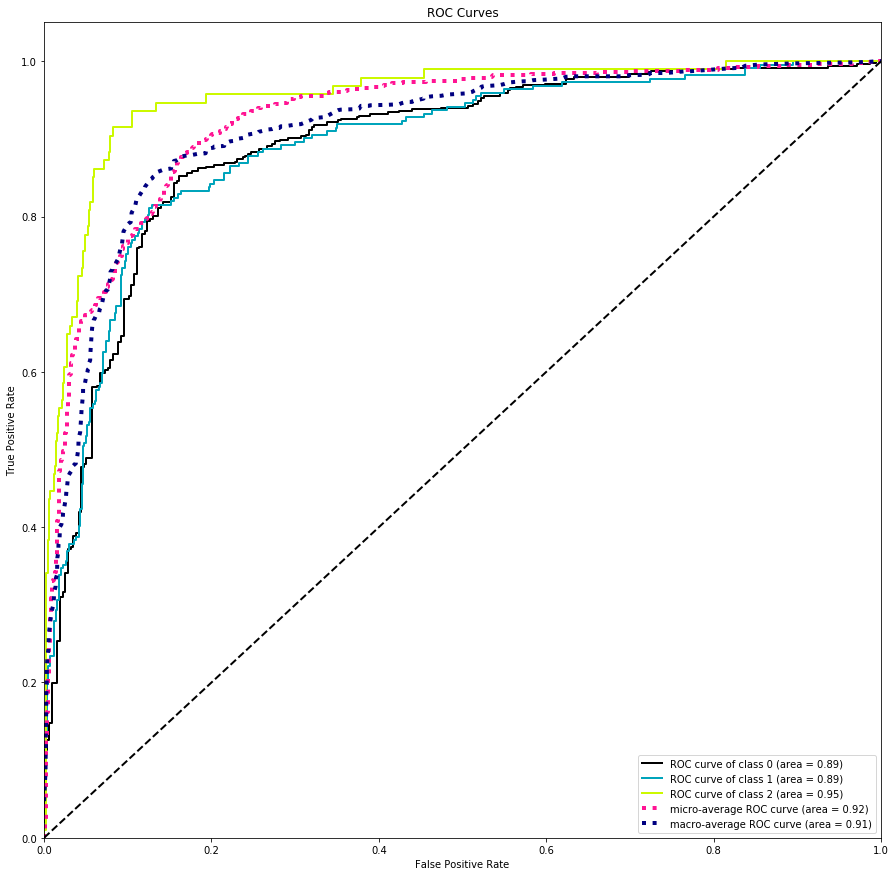

In [38]:
get_roc_curve(val_y,pred_probs,model)

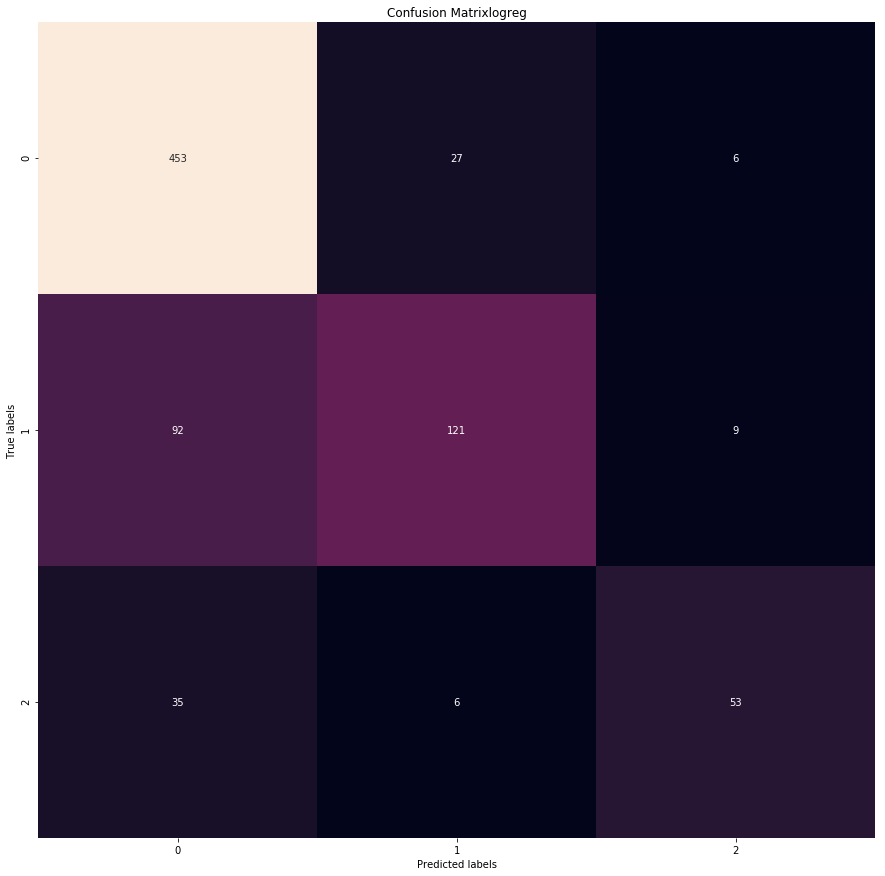

In [39]:
get_confusion_matrix(val_y,pred_val,'logreg')

In [26]:
def searchBestThreshold(start, end, step, pred, y):
    threshold_list = np.arange(start, end, step)
    best_threshold = 0
    best_f05_score = 0
    for i in threshold_list.tolist():
        
        pred_df = pred.applymap(lambda x: 1 if x>i else 0)
        prec = precision_score(y, pred_df.loc[:, 0], average='binary')
        rec = recall_score(y, pred_df.iloc[:, 0], average='binary') 

        fpr, tpr, threshold = metrics.roc_curve(y, pred_df.iloc[:, 0])

        f1_score = 2 * (rec * prec)/ (rec + prec)
        f2_score = 5 * (rec * prec)/ (rec + 4 * prec)
        f05_score = 1.5 * prec * rec / (0.25 * prec + rec)
        
        test_accuracy = metrics.accuracy_score(y.as_matrix().reshape(y.as_matrix().size,1),
                                           pred_df.iloc[:, 0].as_matrix().reshape(pred_df.iloc[:, 0].as_matrix().size,1))
        #if f05_score >= best_f05_score:
        #    best_threshold = round(i, 3)
        #    best_f05_score = round(f05_score, 3)
        if f2_score >= best_f05_score:
            best_threshold = round(i, 3)
            best_f05_score = round(f2_score, 3)
    return best_threshold, best_f05_score

In [27]:
thresholds_dict = {}